In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from torchvision.transforms import transforms

In [3]:
import numpy as np
import cv2

# import matplotlib
import matplotlib.pyplot as plt

In [4]:
from functools import partial

In [5]:
from models import Vgg16Conv
from models import Vgg16Deconv

In [6]:
from utils import decode_predictions

In [7]:
def load_images(img_path):
    # imread from img_path
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # pytorch must normalize the pic by 
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
          transforms.ToTensor()
        , transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    #img_s = img.numpy()
    #img_s = np.transpose(img_s, (1, 2, 0))
    #cv2.imshow("test img", img_s)
    #cv2.waitKey()
    return img

In [8]:
def store(model):
    """
    make hook for feature map
    """
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.pool_locs[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [9]:
def vis_layer(layer, vgg16_conv, vgg16_deconv):
    """
    visualing the layer deconv result
    """
    print(vgg16_conv.feature_maps[layer].shape)
    num_feat = vgg16_conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = vgg16_conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    print(act_lst.size)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != vgg16_conv.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    print(torch.max(new_feat_map[0, mark, :, :]))    
    print('max_activation {}'.format(max_activation))
    
    deconv_output = vgg16_deconv(new_feat_map, layer, mark, vgg16_conv.pool_locs)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    
    print('new_img.shape ' + str(new_img.shape))
    return new_img, int(max_activation)

In [10]:
def vis_forward(layer, vgg16_conv):
    """
    visualing the forward layer feature maps
    """
    
    return vgg16_conv.feature_maps[layer]

In [11]:
if __name__ == '__main__':
    pass
else:
    exit()

In [12]:
# forward processing

vgg16_conv = Vgg16Conv()
vgg16_conv.eval()

store(vgg16_conv)

In [13]:
img_path = './data/dog.jpg'
img = load_images(img_path)

conv_output = vgg16_conv(img)

pool_locs = vgg16_conv.pool_locs
# print(pool_locs)

In [14]:
print('Predicted:')
print(decode_predictions(conv_output, top=3)[0])

Predicted:
[('n02108915', 'French_bulldog', 0.28945642709732056), ('n02096585', 'Boston_bull', 0.12594109773635864), ('n02109047', 'Great_Dane', 0.11997228860855103)]


In [15]:
# backward processing

vgg16_deconv = Vgg16Deconv()
vgg16_deconv.eval()

Vgg16Deconv(
  (features): Sequential(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (1): ReLU()
    (2): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (8): ReLU()
    (9): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (15): ReLU()
    (16): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18

(121, 121, 3)
(224, 224, 3)


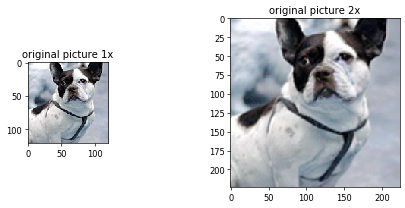

In [16]:
plt.figure(num=None, figsize=(8, 4), dpi=60)

img2 = cv2.imread(img_path)
print(img2.shape)

plt.subplot(1, 4, 1)
plt.title('original picture 1x')
plt.imshow(img2)

img3 = cv2.resize(img2, (224, 224))
print(img3.shape)

plt.subplot(1, 2, 2)
plt.title('original picture 2x')
plt.imshow(img3)

plt.show()

In [17]:
import collections

cfg = {}

cfg[0] = [16, 16,100,  8, 8]
cfg[1] = cfg[0]
cfg[2] = [16, 16,100,  8, 8]
cfg[3] = cfg[2]
cfg[4] = cfg[2]

cfg[5] = [16, 32,100, 16, 8]
cfg[6] = cfg[5]
cfg[7] = [16, 32,100, 16, 8]
cfg[8] = cfg[7]
cfg[9] = cfg[7]

cfg[10] = [16, 64,100, 32, 8]
cfg[11] = cfg[10]
cfg[12] = [16, 64,100, 32, 8]
cfg[13] = cfg[12]
cfg[14] = [16, 64,100, 32, 8]
cfg[15] = cfg[14]
cfg[16] = cfg[14]

cfg[17] = [16,128,100, 64, 8]
cfg[18] = cfg[17]
cfg[19] = [16,128,100, 64, 8]
cfg[20] = cfg[19]
cfg[21] = [16,128,100, 64, 8]
cfg[22] = cfg[21]
cfg[23] = cfg[21]

cfg[24] = [16,128,100, 64, 8]
cfg[25] = cfg[24]
cfg[26] = [16,128,100, 64, 8]
cfg[27] = cfg[26]
cfg[28] = [16,128,100, 64, 8]
cfg[29] = cfg[28]
cfg[30] = cfg[28]

In [18]:
def putImgLine(line):
    
    for i, num in enumerate(line):

        print(str(i) + ', ' + str(num))

In [19]:
def prepareFig(layer):

    plt.figure(num=None, figsize=(cfg[layer][0], cfg[layer][1]), dpi=cfg[layer][2])

    plt.subplots_adjust(top=0.99, bottom=0.01, left=0.05, right=0.95, 
                        hspace=0.35, wspace=0.35)

In [20]:
def drawLayerForward(layer, save=False):

    print(layer)
    if layer == -1 :
      return

    prepareFig(layer)
    imgs = vis_forward(layer, vgg16_conv)[0]

    drawImages(cfg[layer][3], cfg[layer][4], imgs, save)

In [21]:
def drawImages(rows, cols, imgs, save=False):
    
    for i in range(0, len(imgs)):

        plt.subplot(rows, cols, i+1)
        
        img = imgs[i].detach().numpy()
        # print(type(img))
        # print(img.shape)
        
        # img = cv2.resize(img, (imgs.shape[1], imgs.shape[2]))
        plt.imshow(img)

    # plt.title(f'{layer} layer')

    if save:
        figname = 'result' + str(layer) + '.jpg'
        plt.savefig(figname)
        print('result picture has save at ./' + figname)

In [22]:
def vis_backward(layer, layer0, vgg16_conv, vgg16_deconv):

    print(vgg16_conv.feature_maps[layer].shape)
    num_feat = vgg16_conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = vgg16_conv.feature_maps[layer].clone()
    print('new_feat_map.shape ' + str(new_feat_map.shape))
    
    deconv_output = vgg16_deconv(new_feat_map, layer, layer0, -1, vgg16_conv.pool_locs)
    print('deconv_output.shape ' + str(deconv_output.shape))
    '''
    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    print('new_img.shape ' + str(new_img.shape))
    
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    
    print('new_img.shape ' + str(new_img.shape))
    return new_img
    '''
    return deconv_output # [0].detach().numpy()

In [23]:
def drawLayerBackward(layer, layer0, save=False):

    print(layer)
    if layer == -1 :
      return

    prepareFig(layer)

    # img, activation = vis_layer(layer, vgg16_conv, vgg16_deconv)
    imgs = vis_backward(layer, layer0, vgg16_conv, vgg16_deconv)[0]

    drawImages(cfg[layer][3], cfg[layer][4], imgs, save)

In [24]:
print(type(vgg16_conv.features[0]))

print(vgg16_conv.features[0].weight.shape)
print(vgg16_conv.features[0].bias.shape)

<class 'torch.nn.modules.conv.Conv2d'>
torch.Size([64, 3, 3, 3])
torch.Size([64])


In [25]:
'''
for i in range(vgg16_conv.features[0].weight.shape[0]):
    print(i)
    print(vgg16_conv.features[0].weight[i].data)
    print(vgg16_conv.features[0].bias[i].data)
'''

'\nfor i in range(vgg16_conv.features[0].weight.shape[0]):\n    print(i)\n    print(vgg16_conv.features[0].weight[i].data)\n    print(vgg16_conv.features[0].bias[i].data)\n'

<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])


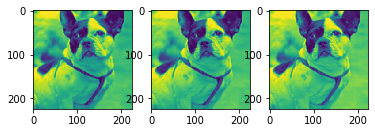

In [26]:
print(type(img))
print(img.shape)
drawImages(1, 3, img[0])

# putImgLine(img[0][1][0])
# putImgLine(img[0][1][1])

In [27]:
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.05, right=0.95, 
                    hspace=0.35, wspace=0.35)
    
# for idx, layer in enumerate([0,1,2,3,4,  5,6,7,8,9,  10,11,12,13,14,15,16,  17,18,19,20,21,22,23,  24,25,26,27,28,29,30]):
for layer in [0]:
    # drawLayerForward(layer) # , save=True)
    pass

<Figure size 432x288 with 0 Axes>

4
torch.Size([1, 64, 112, 112])
new_feat_map.shape torch.Size([1, 64, 112, 112])
forward x.shape torch.Size([1, 64, 112, 112])
idx 26 x.shape torch.Size([1, 64, 224, 224])
idx 27 x.shape torch.Size([1, 64, 224, 224])
deconv_output.shape torch.Size([1, 64, 224, 224])


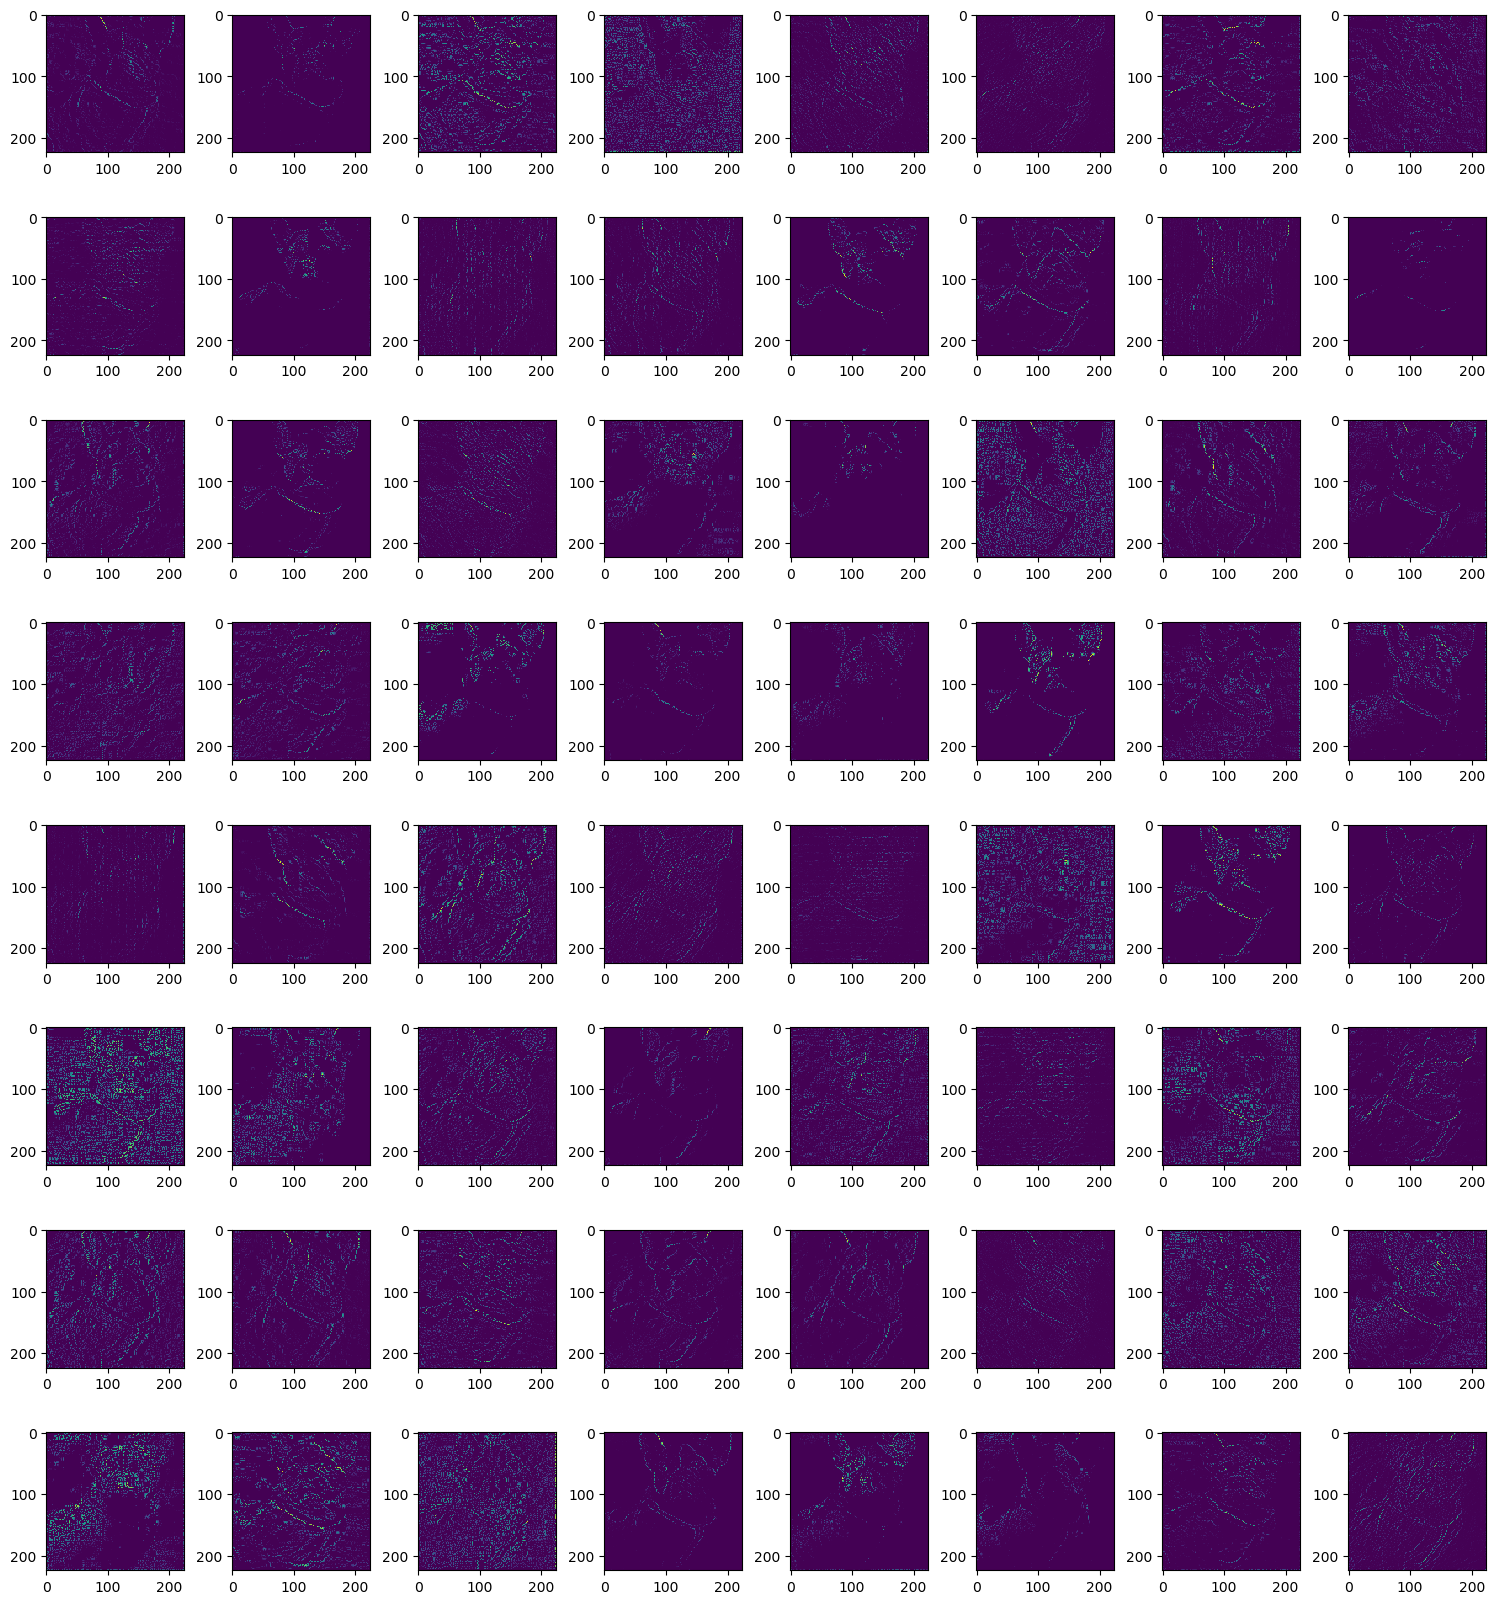

In [28]:
drawLayerBackward(4,3)